## Скачаем необходимые данные и пакеты

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')


In [5]:
data = pd.read_csv('clean_data_MSK.csv', sep=':')
data.iloc[:, :13].head()

,lighting,lat,long,region,category,date,severity,dead,injured,n_participants,dr_exp,w_percent,Температура выше +30С
0,Светлое время суток,55.616777,37.706516,Орехово-Борисово Северное,Наезд на пешехода,2020-03-24 13:06:00,Легкий,0,1,2,[28],0.0,0
1,Светлое время суток,55.841157,37.489332,Головинский,Столкновение,2018-09-15 11:00:00,Легкий,0,1,2,"[20, 6]",0.5,0
2,"В темное время суток, освещение включено",55.713332,37.658944,Даниловский,Наезд на пешехода,2016-04-14 21:25:00,Легкий,0,1,2,[],NaN,0
3,Светлое время суток,55.655243,37.414176,Солнцево,Столкновение,2019-06-20 18:15:00,Легкий,0,1,2,"[12, 1]",0.5,0
4,Светлое время суток,55.756493,37.789315,Перово,Наезд на пешехода,2016-04-04 11:50:00,Легкий,0,1,2,[15],0.0,0


## I. Визуализируем важные временные ряды

### 1) Количество погибших в автокатастрофах с 2015 по 2020 по месяца

In [6]:
df1 = data[['dead']].copy()
df1['dates_monthly'] = pd.PeriodIndex(data['date'], freq='M')
df1 = df1.sort_values(['dates_monthly'])
gb = df1.groupby('dates_monthly').sum()

months = set([*map(lambda x: x.split()[0][:7], data['date'])])
labels_m = [dt if i % 4 == 0 else '' for i, dt in enumerate(sorted(list(months)))]

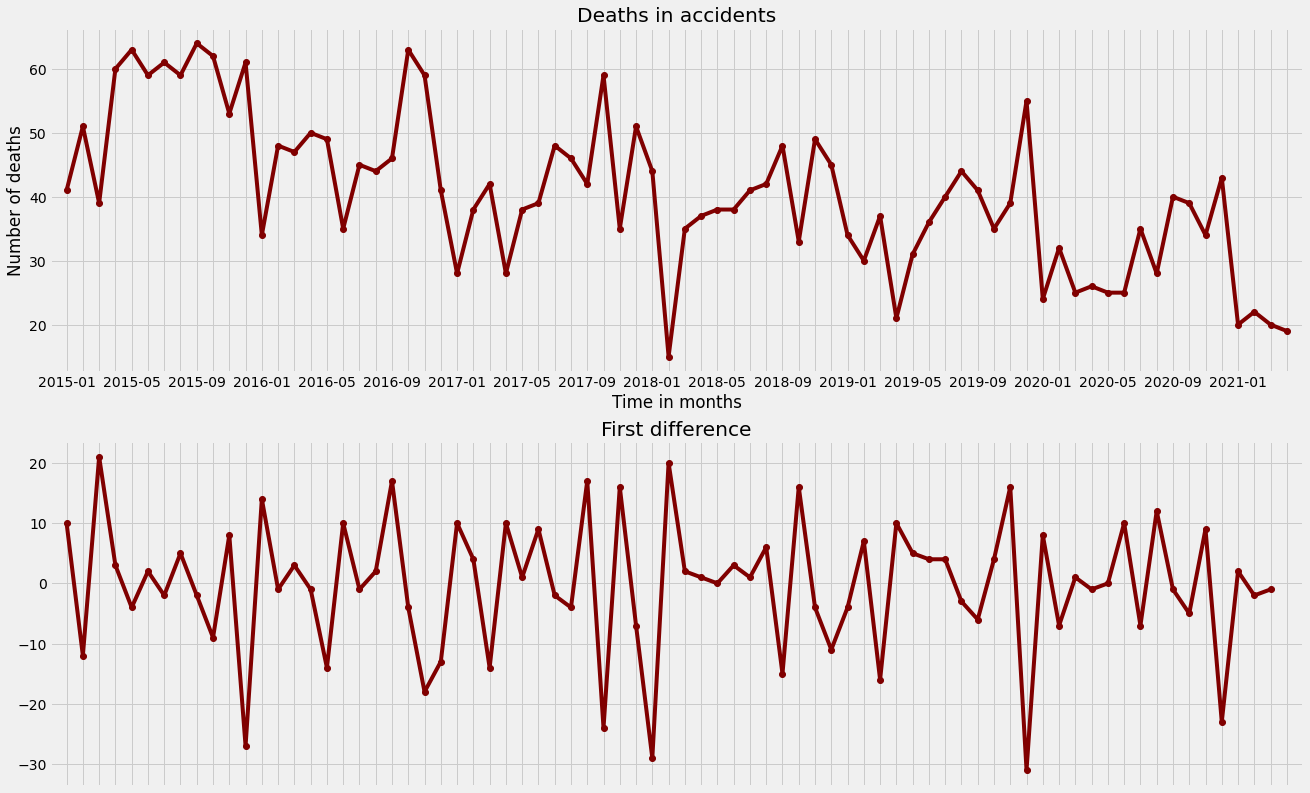

In [7]:
plt.style.use('fivethirtyeight')

_, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 13))

ax1.plot(gb.dead.values, marker='o', c='maroon')
ax1.set_xticks(ticks = np.arange(76))
ax1.set_xticklabels(labels_m)
ax1.set_xlabel('Time in months')
ax1.set_ylabel('Number of deaths')
ax1.set_title('Deaths in accidents')
ax1.set_xlim(-1, 76)

ax2.plot(gb.dead.values[1:] - gb.dead.values[:-1], marker='o', c='maroon')
ax2.set_xticks(ticks = np.arange(76))
ax2.set_xticklabels(['']*76)
ax2.set_title('First difference')
ax2.set_xlim(-1, 76)
plt.show()

The original series is nonstationry: it has seasonality and a trend, however the first difference seems to be stationary

### 2) Количество погибших в автокатастрофах в течение дня и количество автокатастров в течение дня

In [8]:
# making labels for every hour
hours = data['date'].apply(lambda x: x.split()[1][:2]+':00').values
labels_h = sorted(list(np.unique(hours)))

# making a slicec of a dataset 
slice2 = data[['dead']].copy()
slice2['Num_accidents'] = 1
slice2['hours'] = hours
slice2 = slice2.sort_values(['hours'])

# grouping by mean and sum
gb_mean = slice2.groupby('hours').mean()
gb_sum = slice2.groupby('hours').sum()

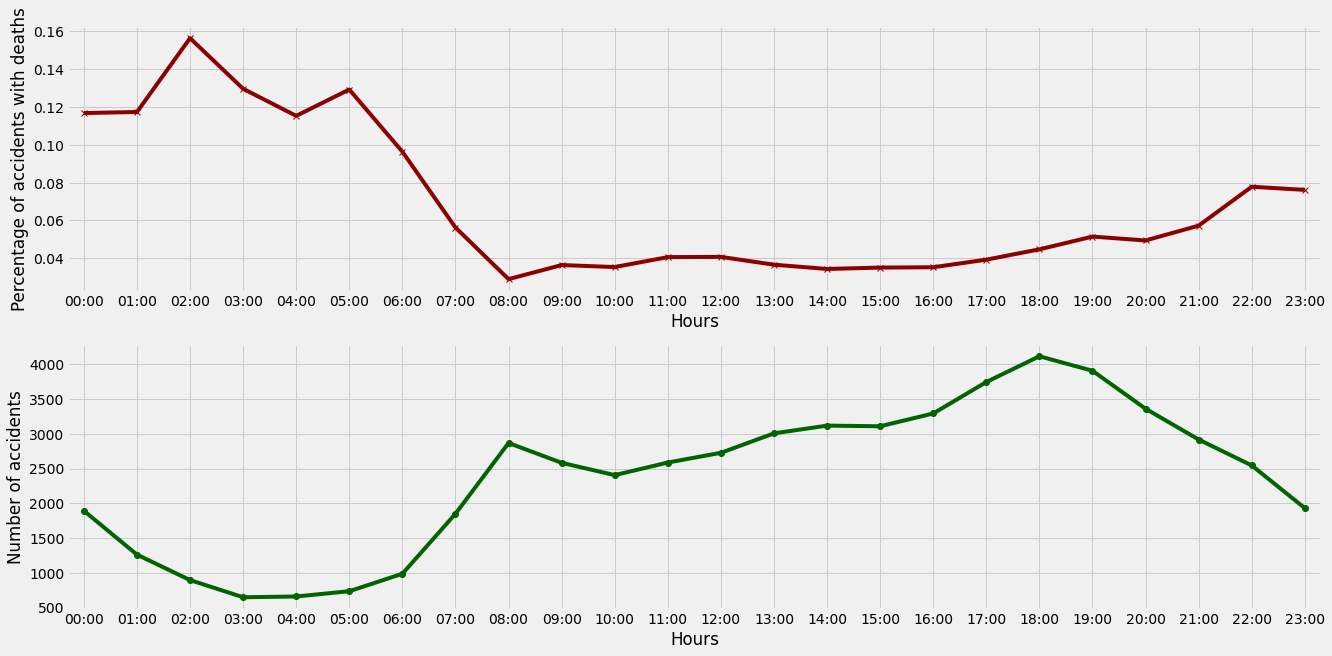

In [9]:
plt.style.use('fivethirtyeight')
_, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))

ax1.plot(gb_mean.dead.values, marker='x', c='darkred')
ax1.set_xticks(ticks=np.arange(24))
ax1.set_xticklabels(labels_h)
ax1.set_xlabel('Hours')
ax1.set_ylabel('Percentage of accidents with deaths')
ax1.set_xlim(-0.3, 23.3)

ax2.plot(gb_sum.Num_accidents.values, marker='o', c='darkgreen')
ax2.set_xticks(ticks=np.arange(24))
ax2.set_xticklabels(labels_h)
ax2.set_xlabel('Hours')
ax2.set_ylabel('Number of accidents')
ax2.set_xlim(-0.3, 23.3)

plt.show()

## II. Создаем модель для предсказывания количества смертей

In [5]:
series = gb.dead.values

# train_test_split
train, test = series[1:64], series[64:]

# first differences train and test
diff = series[1:] - series[:-1]
dtrain, dtest = diff[:-12], diff[-12:]

# shapes of samples
len(train), len(test), len(dtrain), len(dtest)

(63, 12, 63, 12)

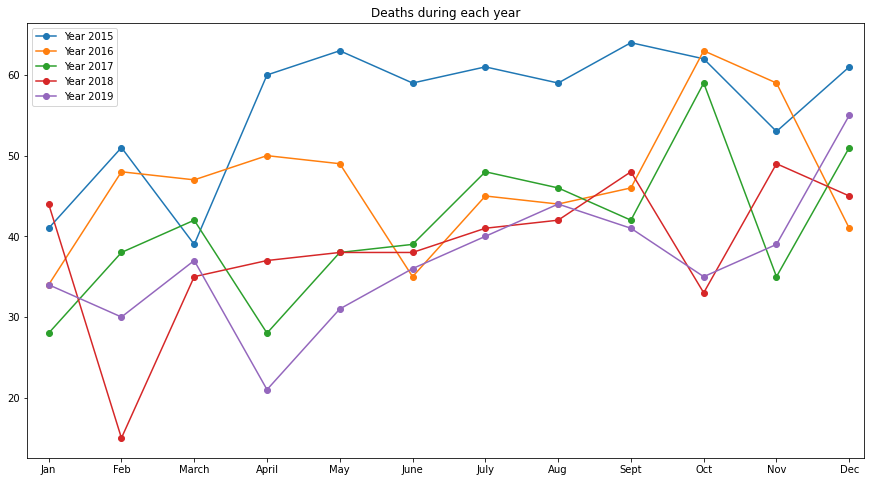

In [6]:
months = ['Jan', 'Feb', 'March', "April", 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']

plt.figure(figsize=(15, 8))
plt.plot(series[:12], marker='o', label='Year 2015')
plt.plot(series[12:24], marker='o', label='Year 2016')
plt.plot(series[24:36], marker='o', label='Year 2017')
plt.plot(series[36:48], marker='o', label='Year 2018')
plt.plot(series[48:60], marker='o', label='Year 2019')
plt.title('Deaths during each year')
plt.xticks(ticks=np.arange(12), labels=months)
plt.xlim(-0.3, 11.2)
plt.legend()
plt.show()

In [9]:
import nest_asyncio
nest_asyncio.apply()

import stan

We are going to use MA process for the first difference

In [10]:
_ARMA101 = """
data {
  int<lower=3> T;  // number of observations
  vector[T] dy;     // observation at time T
}
parameters {
  real mu;              // mean
  real beta;            // term by y_{t-1}
  real<lower=0> sigma;  // error scale
  real theta;      // lag coefficients
}
transformed parameters {
  vector[T] epsilon;    // error terms
  epsilon[1] = dy[1] - mu;
  for (t in 2:T)
    epsilon[t] = (dy[t] - mu
                    - beta * dy[t - 1]
                    - theta * epsilon[t - 1] );
}
model {
  mu ~ normal(0, 2.5);
  beta ~ normal(0, 2.5);
  theta ~ normal(0, 2.5);
  sigma ~ normal(0, 1);
  for (t in 2:T)
    dy[t] ~ normal(mu
                  + beta * dy[t - 1]
                  + theta * epsilon[t - 1],
                  sigma);
}"""

In [11]:
data = {
    'T': 63,
    'dy': dtrain
}

In [12]:
posterior = stan.build(_ARMA101, data=data)
fit = posterior.sample(num_samples=1000)

Building...
Found model in cache. Done.
Sampling...
    0/8000 [>---------------------------]   0%  1 sec/0     
 8000/8000 [============================] 100%  1 sec/0   Messages received during sampling:
  Gradient evaluation took 6.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.69 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.59 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.53 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.17 seconds.
  Adjust your expectations accordingly!

 8000/8000 [============================] 100%  1 sec/0     
Done.


In [13]:
params = fit.to_frame()
params.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu,beta,sigma,...,epsilon.54,epsilon.55,epsilon.56,epsilon.57,epsilon.58,epsilon.59,epsilon.60,epsilon.61,epsilon.62,epsilon.63
draws,,,,,,,,,,,,,,,,,,,,,
0,-204.425751,0.992459,0.207195,4.0,15.0,0.0,205.120075,-0.186821,0.109278,7.508212,...,6.910012,8.772810,3.126934,-3.212280,2.507384,17.572404,-19.787706,-2.809853,-9.729971,-5.121248
1,-204.425751,0.992459,0.207195,4.0,15.0,0.0,205.120075,-0.186821,0.109278,7.508212,...,6.910012,8.772810,3.126934,-3.212280,2.507384,17.572404,-19.787706,-2.809853,-9.729971,-5.121248
2,-204.425751,0.992459,0.207195,4.0,15.0,0.0,205.120075,-0.186821,0.109278,7.508212,...,6.910012,8.772810,3.126934,-3.212280,2.507384,17.572404,-19.787706,-2.809853,-9.729971,-5.121248
3,-204.425751,0.992459,0.207195,4.0,15.0,0.0,205.120075,-0.186821,0.109278,7.508212,...,6.910012,8.772810,3.126934,-3.212280,2.507384,17.572404,-19.787706,-2.809853,-9.729971,-5.121248
4,-204.407900,0.611396,0.207195,3.0,11.0,0.0,205.504193,-0.185001,0.303557,7.152718,...,4.993521,7.727349,3.331454,-1.730955,4.357521,19.121528,-17.457710,0.965930,-8.323356,-4.618508


In [36]:
params = fit.to_frame()
mu = params['mu'].mean()
sigma = params['sigma'].mean()
beta = params['beta'].mean()
# beta2 = params['beta2'].mean()
th1 = params['theta'].mean()
# th2 = params['theta.2'].mean()
err1 = params['epsilon.62'].mean()
err2 = params['epsilon.63'].mean()
errs = [err1, err2]

In [69]:
np.random.seed(43)
dpred = [1]
for i in range(2, 14):
    dy = np.random.normal(loc = mu 
                                + beta * dpred[-1]
                                # + beta2 * dpred[-2] 
                                + th1 * errs[i - 1] 
                                # + th2 * errs[i - 2] 
                                , scale = sigma, size=100000)
    dpred += [dy]
    errs += [dy - dtest[i - 2]]
dpred = dpred[1:] 
print(len(dpred))
assert len(dpred) == 12

12


In [82]:
pred = [25]
for dy in dpred:
    pred += [pred[-1] + dy]

pred = pred[1:]
assert len(pred) == 12

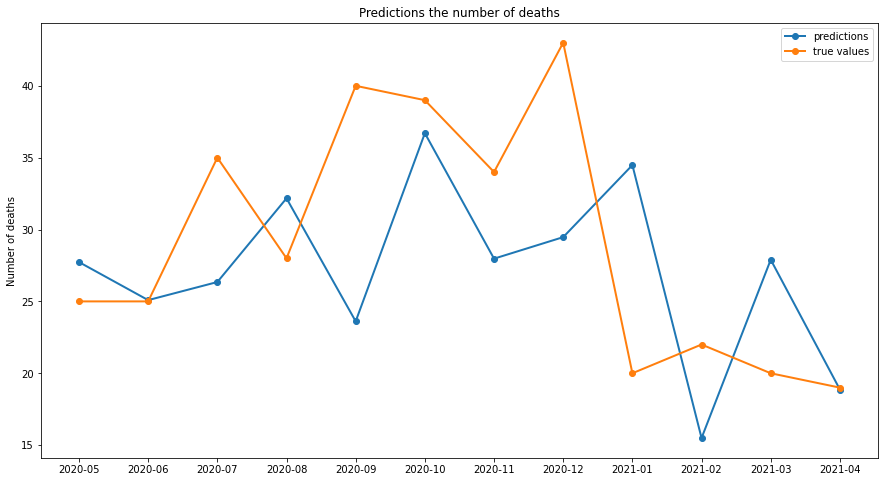

In [83]:
labels = ['2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10',
             '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', '2021-04']

plt.figure(figsize=(15, 8))
plt.plot(np.array(pred).mean(axis=1), lw = 2, marker='o',  label='predictions')
plt.plot(test, lw = 2, marker='o',  label='true values')
plt.ylabel('Number of deaths')
plt.xticks(ticks=np.arange(12), labels=labels)
plt.title('Predictions the number of deaths')
plt.legend()
plt.show()

In [84]:
from sklearn.metrics import mean_absolute_percentage_error as mape

In [85]:
y_pred = np.array(pred).mean(axis=1)
y_true = test
mape(y_true, y_pred)

0.24096058842174892